# AODAPI viability and inflection points

In [1]:
import numpy as np
import scipy.optimize as optim
import math
import os,sys
import pandas as pd
import copy
import scipy.stats as st
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib import rcParams

import BA_C

import random as rand

import scipy.stats as st

import seaborn as sns

from sklearn.metrics import auc

import copy

In [2]:
def nonlinear(x,a,b):
    return (a*(np.power(x,b)))

In [3]:
def linear(x,a,b):
    return (a + b*x)

In [4]:
def gradient(x,a,b):
    #return np.array([x**b,(a*b*(x**(b-1)))])
    return np.array([x**b,a*np.multiply(np.log(x),np.power(x,b))])

**Read viability and T2 inflection points**

In [5]:
cwd = os.getcwd()
data_directory = '/Users/sns9/CodeX/ProVia/data/AODAPI'
os.chdir(data_directory)

aodapi_T2 = pd.read_csv('AODAPI-T2paired-Day1-totalset-2.csv')

column_names = list(aodapi_T2)

aodapis, t2s, ths = {}, {}, {}

for c in column_names:
    if 'T2' in c:
        t2s[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        print(c,'\t',t2s[c])
        
    if 'AODAPI' in c:
        aodapis[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        print(c,'\t',aodapis[c])
        
    if 'TH' in c:
        ths[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        print(c,'\t',ths[c])

Study1_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study1_AODAPI 	 [91.05, 90.42, 85.12, 78.8, 77.35, 65.49]
Study1_T2 	 [74.93, 122.59, 104.11, 164.45, 150.77, 193.53]
Study3_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study3_AODAPI 	 [96.18, 94.71, 89.54, 83.76, 71.59, 68.47]
Study3_T2 	 [102.31, 80.83, 85.02, 126.79, 147.27, 178.04]
Study4_TH 	 [0.0, 5.0, 15.0]
Study4_AODAPI 	 [97.09, 91.58, 77.33]
Study4_T2 	 [93.02, 113.0, 193.43]
Study5_TH 	 [0.0, 5.0, 15.0]
Study5_AODAPI 	 [91.72, 94.21, 63.61]
Study5_T2 	 [71.64, 72.14, 159.66]
Study6_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study6_AODAPI 	 [99.28, 99.42, 98.61, 96.51, 86.48, 63.57]
Study6_T2 	 [66.74, 72.94, 72.54, 85.82, 120.29, 181.44]
Study7_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study7_AODAPI 	 [99.05, 99.48, 99.12, 97.0, 70.68, 56.62]
Study7_T2 	 [61.85, 65.04, 70.54, 78.83, 139.58, 196.32]
Study8_TH 	 [0, 5, 10, 15, 20, 30, 40, 60]
Study8_AODAPI 	 [94.96, 89.8, 91.7, 87.23, 83.28, 76.51, 68.03, 59.75]
Study8_T2 	 [90.32, 109.1, 

**Fit $\log[\mathrm{AODAPI}]$-vs-T2.**

In [6]:
x, y = [], []

for c in aodapis.keys():
    x += aodapis[c]

for c in t2s.keys():
    y += t2s[c]
    
dof = len(x) - 2
    
x = np.array(x)/100
y = np.array(y)
    
result = st.linregress(np.log(x),np.log(y),alternative='two-sided')
#result = st.linregress(x,y,alternative='two-sided')
    
print(result)    

a = math.exp(result.intercept)
b = result.slope

mean_aodapi = np.linspace(50,100,100)
t2 = np.exp(result.slope*np.log(mean_aodapi/100) + result.intercept)

fitname = r'T2 = ' + str(round(math.exp(result.intercept),2)) + '(AODAPI/100)$^{'+ str(round(result.slope,1)) + '}$'

LinregressResult(slope=-1.8094421307788604, intercept=4.403098255195571, rvalue=-0.9176058584619325, pvalue=1.5080576362327394e-28, stderr=0.09575885833756317, intercept_stderr=0.025618762473214825)


popt, pcov = optim.curve_fit(linear,np.log(x),np.log(y))
p_std = np.sqrt(np.diag(pcov))

mean_aodapi = np.linspace(50,100,100)
t2 = np.exp(popt[1]*np.log(0.01*mean_aodapi) + popt[0])

fitname = r'T2$_{\mathrm{est}}$ = ' + str(round(math.exp(popt[0]),2)) + '(AODAPI/100)$^{'+ str(round(popt[1],1)) + '}$'

In [7]:
results = optim.curve_fit(nonlinear,x,y,full_output=True)

popt, pcov = results[0], results[1]

p_std = np.sqrt(np.diag(pcov))
norm_pcov = np.ones(shape=pcov.shape)
norm_pcov[0,1] = pcov[0,1]/(p_std[0]*p_std[1])
norm_pcov[1,0] = pcov[0,1]/(p_std[0]*p_std[1])

print(popt)
print(pcov)
print(norm_pcov)
print(np.sqrt(np.diag(pcov)))

mean_aodapi = np.linspace(50,100,100)
t2 = nonlinear(0.01*mean_aodapi,popt[0],popt[1])

fitname = r'T2 = ' + str(round(popt[0],2)) + '(AODAPI/100)$^{'+ str(round(popt[1],1)) + '}$'

[85.76774746 -1.65693052]
[[7.77605541e+00 2.06934408e-01]
 [2.06934408e-01 7.52945673e-03]]
[[1.         0.85520694]
 [0.85520694 1.        ]]
[2.78855794 0.08677244]


**Reduced $\chi^2$ error:**

In [8]:
residual = nonlinear(x,popt[0],popt[1]) - y
#residual = result.slope*x + result.intercept - y

norm_RSS = math.sqrt(np.dot(residual,residual)/(x.shape[0]-2))

print(norm_RSS)

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

18.439213970459075


true_residual = a*np.power(x,b) - y

norm_RSS = math.sqrt(np.dot(true_residual,true_residual)/(x.shape[0]-2))
print(norm_RSS)

RSS_text = r'$\sqrt{\mathrm{RSS/dof}}$ = ' + str(round(norm_RSS,2)) + ' h'

**Compute upper and lower bounds of the fit using 95% CI of the fit parameters.**

In [9]:
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)

s_err = ts*result.stderr
i_err = ts*result.intercept_stderr

print(ts)

1.996008353475506


In [10]:
s_up, i_up = result.slope + s_err, result.intercept - i_err
s_low, i_low = result.slope - s_err, result.intercept + i_err

t2_up = np.exp(s_up*np.log(mean_aodapi/100) + i_up)
t2_low = np.exp(s_low*np.log(mean_aodapi/100) + i_low)

In [11]:
n_samples = 10000

s_is, i_is = [], []

t2_up = np.zeros(shape=mean_aodapi.shape)
t2_low = np.zeros(shape=mean_aodapi.shape)

rt2_up = np.zeros(shape=mean_aodapi.shape)
rt2_low = np.zeros(shape=mean_aodapi.shape)

effective_sigma = np.zeros(shape=mean_aodapi.shape)

for i in range(0,mean_aodapi.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(nonlinear(0.01*mean_aodapi[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    #t2_low[i], t2_up[i] = ci[0], ci[1]
    
    t2_low[i], t2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = t2[i] - sigma*ts, t2[i] + sigma*ts

s_is, i_is = [], []

t2_up = np.zeros(shape=mean_aodapi.shape)
t2_low = np.zeros(shape=mean_aodapi.shape)

st2_up = np.zeros(shape=mean_aodapi.shape)
st2_low = np.zeros(shape=mean_aodapi.shape)

sigma = np.zeros(shape=mean_aodapi.shape)

for i in range(0,mean_aodapi.shape[0]):
    samples = []
    
    x = 0.01*mean_aodapi[i]
    
    #G = np.array([x**popt[1],popt[0]*popt[1]*(x**(popt[1]-1))])
    
    G = gradient(x,popt[0],popt[1])
    
    c = np.matmul(np.transpose(G),np.matmul(pcov,G))
    
    #print(0.01*mean_aodapi[i],math.exp(result.intercept),result.slope,f,G)
    
    ci = math.sqrt(c + reduced_chi2**2)*ts
    
    #ci = math.sqrt(c)*ts
    
    sigma[i] = ci
    
    #t2_low[i], t2_up[i] = math.exp(math.log(t2[i]) - ci), math.exp(math.log(t2[i]) + ci)
    
    t2_low[i], t2_up[i] = t2[i] - ci, t2[i] + ci
    
    #st2_low[i], st2_up[i] = t2[i] - math.sqrt(c), t2[i] + math.sqrt(c)

[ 0.  5. 10. 15. 20. 30.]
[ 0.  5. 10. 15. 20. 30.]
[ 0.  5. 15.]
[ 0.  5. 15.]
[ 0.  5. 10. 15. 20. 30.]
[ 0.  5. 10. 15. 20. 30.]
[ 0  5 10 15 20 30 40 60]
[ 0  5 10 15 20 30 40 60]
[ 0  5 10 15 20 30 40 60]
[ 0  5 10 15 20 30 40 60]
[ 0.  5. 10. 15. 20. 30. 40.]


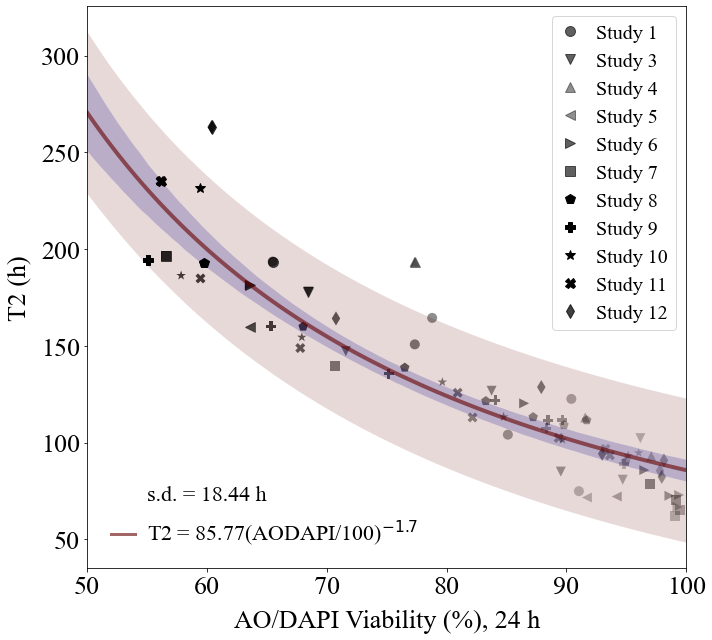

In [12]:
#studies = ['Study1','Study3','Study4','Study5','Study7']#,'Study8','Study9']

all_markers = ["o","v","^","<",">","s","p","P","*","X","d","D"]

studies = ['Study1','Study3','Study4','Study5','Study6','Study7','Study8','Study9','Study10','Study11','Study12']

#fig, axs = plt.subplots(figsize=(8,7))
fig, axs = plt.subplots(figsize=(10,9))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

#color_list = {'Study1':'blue','Study3':'green','Study4':'black','Study5':'m','Study7':'orange','Study8':'brown','Study9':'#8899aa'}
#color_list = {'Study1':'blue','Study3':'green','Study4':'black','Study5':'m','Study6':'red','Study7':'#667788','Study8':'c','Study9':'orange','Study10':'darkred','Study11':'lime','Study12':'darkgoldenrod'}


color_list = {'Study1':'red','Study3':'blue','Study4':'green',
              'Study5':'black','Study6':'c','Study7':'m',
              'Study8':'orange','Study9':'darkred','Study10':'lime',
              'Study11':'slategray','Study12':'darkgoldenrod'}


#plt.plot(mean_aodapi,t2,linewidth=4,color='#880000',alpha=0.6,label=fitname)

mi = 0

for s in studies:
    labelname = s.replace('Study','Study ')
    
    print(np.array(ths[s+'_TH']))
    
    alpha_s = 0.75*np.array(ths[s+'_TH'])/60.0 + 0.25
    
    plt.scatter(aodapis[s+'_AODAPI'],t2s[s+'_T2'],marker=all_markers[mi],s=100,color='black',alpha=alpha_s,linewidth=0)

    plt.plot(aodapis[s+'_AODAPI'][-1],t2s[s+'_T2'][-1],marker=all_markers[mi],ms=10,color='black',alpha=alpha_s[-1],linewidth=0,label=labelname)

    #plt.plot(aodapis[s+'_AODAPI'],t2s[s+'_T2'],marker=all_markers[mi],ms=10,color='black',alpha=0.9,linewidth=0,label=labelname)

    mi += 1
    
plt.plot(mean_aodapi,t2,linewidth=4,color='#660000',alpha=0.6)

plt.fill_between(mean_aodapi,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(mean_aodapi,rt2_up,rt2_low,alpha=0.2,color='#000088',linewidth=0.0)

plt.xticks(size=26)
plt.yticks(size=26)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(r'AO/DAPI Viability (%), 24 h',size=26,labelpad=10)
plt.ylabel(r'T2 (h)',size=26,rotation=90,labelpad=10)
plt.xlim(50,100)
#plt.ylim(0,400)

plt.plot(np.linspace(52,54,2),53*np.ones(2,),color='#660000',alpha=0.6,lw=3)

plt.text(55,70,RSS_text,fontsize=22)
plt.text(55,50,fitname,fontsize=22)

#plt.yscale('log')
plt.legend(frameon=True,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper right')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

#plt.savefig('AODAPI_48h-vs-T2_(corrected)-v3.png',dpi=300)

fig, axs = plt.subplots(figsize=(7,7))



#im = sns.histplot(x=a_samples, y=b_samples, bins=100, pthresh=.1, cmap="mako", cbar=True)

im = sns.kdeplot(x=a_samples, y=b_samples, cmap="mako_r",fill=True,levels=20)

#sns.jointplot(x=a_samples, y=b_samples, bins=100, kind='hex', color="#4CB391")

plt.xlim(78,95)
plt.ylim(-1.9,-1.4)
plt.xticks(size=24)
plt.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(r'$\alpha$',size=30,labelpad=10)
plt.ylabel(r'$\beta$',size=30,rotation=90,labelpad=10)

plt.tight_layout()

plt.savefig('kde-alpha_beta.png',dpi=300)

In [13]:
data_folder = '/Users/sns9/CodeX/ProVia/data/cutoff'
os.chdir(data_folder)

# False positivity rate
pvalue = 0.5

T2_cutoff = np.zeros(shape=mean_aodapi.shape)

wf = open('aodapi_t2_mean.csv','w')

for i in range(0,mean_aodapi.shape[0]):
    #probs[k][i] = st.norm.sf(k,loc=t2[i],scale=sigma[i])
    T2_cutoff[i] = st.t.ppf(1-pvalue,df=dof,loc=t2[i],scale=effective_sigma[i])
    
    print(str(mean_aodapi[i])+','+str(T2_cutoff[i]),file=wf)
    
wf.close()

data_directory = '/Users/sns9/CodeX/ProVia/data/AODAPI'
os.chdir(data_directory)

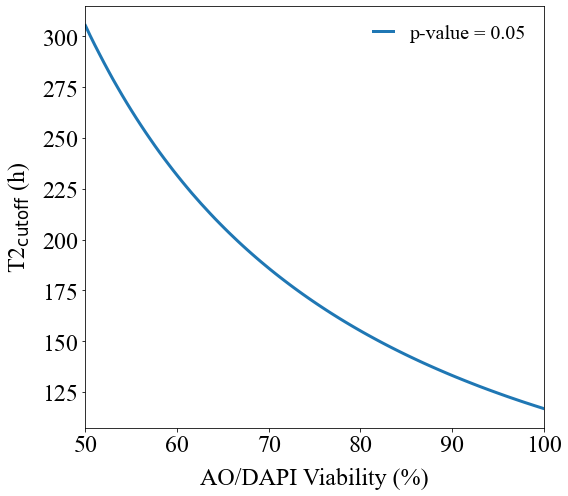

In [14]:
#fig, axs = plt.subplots(figsize=(8,7))
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(mean_aodapi,T2_cutoff,lw=3.0,label=r'p-value = 0.05')
        
plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel(r'AO/DAPI Viability (%)',size=24,labelpad=10)
plt.ylabel(r'T2$_{\mathrm{cutoff}}$ (h)',size=24,rotation=90,labelpad=10)
plt.xlim(50,100)
#plt.ylim(0,1.75)
plt.legend(frameon=False,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='best')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

#plt.savefig('AODAPI-T2-cutoff_prob-v2.png',dpi=300)

In [15]:
mean_aodapi2 = np.linspace(40,100,1000)

n_samples = 10000

s_is, i_is = [], []

t2 = np.zeros(shape=mean_aodapi2.shape)

t2_up = np.zeros(shape=mean_aodapi2.shape)
t2_low = np.zeros(shape=mean_aodapi2.shape)

rt2_up = np.zeros(shape=mean_aodapi2.shape)
rt2_low = np.zeros(shape=mean_aodapi2.shape)

effective_sigma = np.zeros(shape=mean_aodapi2.shape)

for i in range(0,mean_aodapi2.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
    
    t2[i] = nonlinear(0.01*mean_aodapi2[i],popt[0],popt[1])
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(nonlinear(0.01*mean_aodapi2[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    #t2_low[i], t2_up[i] = ci[0], ci[1]
    
    t2_low[i], t2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = t2[i] - effective_sigma[i], t2[i] + effective_sigma[i]

In [16]:
#test_t2s = [100,150,200,250,300]
test_t2s = [96,108,120,132,144,156,168,180,192,204,216,228,240,252,264]
#test_t2s = [96,120,144,168,192,216,240,264]
#test_t2s = [96,144,192,240]

#test_t2s = list(np.linspace(96,264,6))
print(test_t2s[1] - test_t2s[0])

test_t2s.reverse()
#print(test_t2s)
#test_t2s = list(np.linspace(72,264,16))
cutoff_probs = {}
pdfs = {}
cdfs = {}

for k in test_t2s:
    cutoff_probs[k] = np.zeros(shape=mean_aodapi2.shape)
    pdfs[k] = np.zeros(shape=mean_aodapi2.shape)
    cdfs[k] = np.zeros(shape=mean_aodapi2.shape)
    
responses = np.zeros(shape=(len(test_t2s),mean_aodapi2.shape[0]))

j = 0

for k in test_t2s:
    for i in range(0,mean_aodapi2.shape[0]):
        cutoff_probs[k][i] = st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        pdfs[k][i] = st.t.pdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        #cdfs[k][i] = st.t.cdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        
    pdfs[k] *= 1.0/np.sum(pdfs[k])
    x = copy.deepcopy(pdfs[k][::-1])
    sum_x = np.array([np.sum(x[m:]) for m in range(0,pdfs[k].shape[0])])
    
    cdfs[k] = sum_x[::-1]
    
    responses[j,:] = pdfs[k]
    
    j += 1
    
c, e, p = BA_C.get_CC(responses)
print(c)

12
1.594888807309742


In [95]:
n_samples = 10000

sample_T2s = np.zeros(shape=(mean_aodapi2.shape[0],n_samples))
selected_subsamples = {}

for i in range(0,mean_aodapi2.shape[0]):
    sample_T2s[i,:] = st.t.rvs(df=dof,loc=t2[i],scale=effective_sigma[i],size=n_samples)

ik = 0

for k in test_t2s:
    t2_ll, t2_hh = k-1, k+1
    
    selected_subsamples[k] = np.zeros(shape=(mean_aodapi2.shape[0],))
    
    for i in range(0,mean_aodapi2.shape[0]):
        sub_sample1 = sample_T2s[i,:][sample_T2s[i,:]>t2_ll]
        sub_sample2 = sub_sample1[sub_sample1<t2_hh]

        selected_subsamples[k][i] = len(sub_sample2)
    
    selected_subsamples[k] *= 1.0/np.sum(selected_subsamples[k]) 

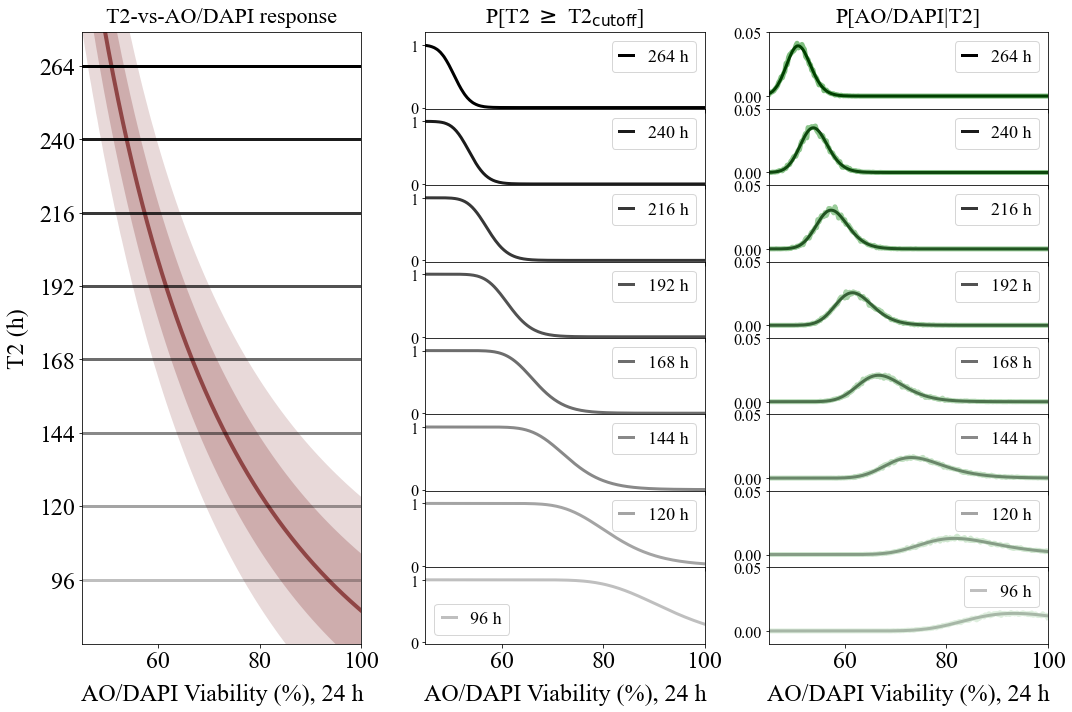

In [96]:
fig = plt.figure(tight_layout=True,figsize=(15,10))
gs = fig.add_gridspec(len(test_t2s),3, hspace=0)

ax = fig.add_subplot(gs[:,0])
ax.plot(mean_aodapi2,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)
ax.fill_between(mean_aodapi2,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
ax.fill_between(mean_aodapi2,rt2_up,rt2_low,alpha=0.2,color='#660000',linewidth=0.0)

ax.set_title(r'T2-vs-AO/DAPI response',size=22,pad=10)

ax.tick_params(axis='both',labelsize=24)
ax.set_yticks(test_t2s)
#ax.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'AO/DAPI Viability (%), 24 h',size=24,labelpad=10)
ax.set_ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
ax.set_ylim(75,275)
ax.set_xlim(45,100)

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_aodapi2,t*np.ones(shape=mean_aodapi2.shape[0]),color='black',lw=3,alpha=_alpha)

for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,1])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_aodapi2,cutoff_probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylim(-0.02,1.2)
    ax.set_xlim(45,100)
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title(r'P[T2 $\geq$ T2$_{\mathrm{cutoff}}$]',size=22,pad=10)
        
ax.set_xlabel(r'AO/DAPI Viability (%), 24 h',size=24,labelpad=10)
        
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,2])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_aodapi2,pdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    
    ax.plot(mean_aodapi2,selected_subsamples[test_t2s[k]],lw=5,color='green',alpha=0.5*_alpha)
    
    ax.tick_params(axis='y',labelsize=12)
    #ax.set_ylim(-0.02,1.2)
    ax.set_xlim(45,100)
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.set_ylim(-0.01,0.05)#1.2*np.max(probs_2[test_t2s[k]]))
    
    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title('P[AO/DAPI|T2]',size=22,pad=10)
          
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'AO/DAPI Viability (%), 24 h',size=24,labelpad=10)

#ax.plot(np.arange(0, 1e6, 1000))
#ax.set_ylabel('YLabel0')
#ax.set_xlabel('XLabel0')

plt.savefig('AODAPI-T2-probabilities-combined-s10000.png',dpi=300)

In [66]:
test_t2s.reverse()

wf = open('AODAPI-T2-cutoff0.05.csv','w')

print('T2_cutoff,p-value,AO/DAPI')


for k in test_t2s:
    for i in range(0,mean_aodapi2.shape[0]):
        a = round(st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i]),3)
        
        if a<=0.05:
            v = round(mean_aodapi2[i],1)
            break
        else:
            v = 'N/A'
    
    #print(k,a,v)
    
    outstring = str(k) + ',' + str(a) + ',' + str(v)
    
    print(outstring,file=wf)
    
wf.close()

T2_cutoff,p-value,AO/DAPI


fig, axs = plt.subplots(figsize=(5,10))

plt.plot(mean_aodapi2,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)

plt.fill_between(mean_aodapi2,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(mean_aodapi2,rt2_up,rt2_low,alpha=0.2,color='#660000',linewidth=0.0)

plt.xticks(size=24)
plt.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(r'AO/DAPI Viability (%)',size=24,labelpad=10)
plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
plt.xlim(45,100)

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    plt.plot(mean_aodapi2,t*np.ones(shape=mean_aodapi2.shape[0]),color='black',lw=3,alpha=_alpha)
    
plt.tight_layout()

#plt.savefig('AODAPI_24h-vs-T2-probs.png',dpi=300)

fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(len(test_t2s), hspace=0)

axs = gs.subplots(sharex=True)

for k in range(0,len(test_t2s)):
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    axs[k].plot(mean_aodapi2,probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    axs[k].tick_params(axis='y',labelsize=12)
    axs[k].set_xlim(45,102)
    
    
    axs[k].set_ylim(-0.005,1.2*np.max(probs[test_t2s[k]]))
    
    #plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
    
    axs[k].legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    if k==4:
        axs[k].set_ylabel(r'P[AO/DAPI Viability (%)]',size=24,rotation=90,labelpad=10)
    
plt.xticks(size=24) 
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(r'AO/DAPI Viability (%)',size=24,labelpad=10)
#plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)

plt.tight_layout()

#plt.savefig('T2-cuts.png',dpi=300)

#fig, axs = plt.subplots(figsize=(8,7))
#fig, axs = plt.subplots(figsize=(10,9))
fig, axs = plt.subplots(figsize=(11,8))

test_t2s.reverse()

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

lmin, lmax = 2, 5
w = len(test_t2s)

i = 0

for k in test_t2s:
    lw_i = lmin + i*(lmax - lmin)/w
    
    plt.plot(mean_aodapi2,probs[k],lw=lw_i,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' h')
    #plt.plot(probs[k],mean_aodapi,lw=3.0,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' h')
    
    i += 1
    
plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel(r'AO/DAPI Viability (%)',size=24,labelpad=10)
plt.ylabel(r'P[T2$_{\mathrm{expected}} \geq$T2$_{\mathrm{cutoff}}$]',size=24,rotation=90,labelpad=10)
#plt.ylabel(r'P[AO/DAPI Viability (%)]',size=24,rotation=90,labelpad=10)
plt.xlim(40,100)
#plt.ylim(0,2.5)
plt.legend(frameon=True,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=0.5,loc='center left',bbox_to_anchor=(1, 0.5))

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

#plt.savefig('AODAPI-T2-cutoff_prob-pdf-48h.png',dpi=300)

1
[0, 1, 2, 3, 4, 5]
0.8971897595732391


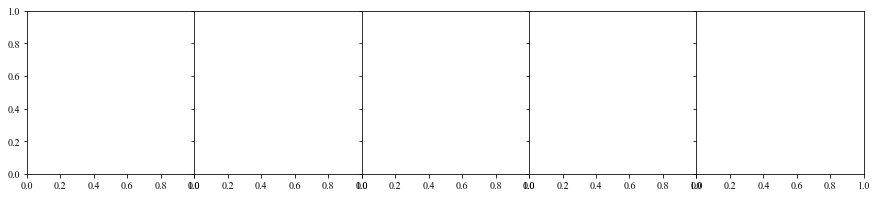

In [73]:
wd = 3

data_skip = 1#int((len(test_t2s)-1)/3)
print(data_skip)

good_indices = [0]

for kk in range(1,len(test_t2s)):
    this_index = good_indices[-1] + data_skip
    
    if this_index>len(test_t2s):
        break
    else:
        good_indices.append(this_index)
    
print(good_indices)

#l = int((len(test_t2s)-1)*wd)

l = int((len(good_indices)-1)*wd)

fig = plt.figure(figsize=(l,wd))
#gs = fig.add_gridspec(ncols=len(test_t2s)-1, nrows=1, wspace=0)
gs = fig.add_gridspec(ncols=len(good_indices)-1, nrows=1, wspace=0)

axs = gs.subplots(sharex=True,sharey=True)

all_aucs = []

test_t2s = test_t2s[::-1]

#for k in range(0,len(test_t2s)-1):
for ik in range(0,len(good_indices)-1):
    k = good_indices[ik]
    
    dx = cdfs[test_t2s[k]][::-1]
    dy = cdfs[test_t2s[k+1]][::-1]
    
    all_aucs.append(auc(dx,dy))
    
    #all_aucs.append(np.trapz(dx,dy))
    
    label_text = str(round(all_aucs[-1],3))
    
    #axs[ik].plot(dx,dy,lw=2,color='black',label=label_text)
    #axs[ik].fill_between(dx,dy,0,color='black',alpha=0.3)#,label=str(test_t2s[k])+' h',alpha=_alpha)
    #axs[ik].set_xticks((0,1))
    #axs[ik].set_yticks((0,1))
    #axs[ik].tick_params(axis='both',labelsize=16)
    #axs[ik].legend(frameon=False,prop={'size': 18,'family':'Arial'},markerscale=1.0,handlelength=0.0,loc='lower right')
    #axs[ik].set_title(str(test_t2s[k])+'h - '+str(test_t2s[k+1])+'h',fontsize=16)
    
    #if k%2==0:
    #    axs[k].xaxis.tick_top()
    
        
        
    #axs[k].set_title('AUC = '+str(round(all_aucs[-1],3)),fontsize=16)
    
        
print(max(all_aucs))
#plt.tight_layout()
#plt.savefig('AODAPI-AUC-48h-small.png',dpi=300)  

try:
    wf = open('min_AUC_summary.csv','a')
    wf.close()
except FileNotFoundError:
    wf = open('min_AUC_summary.csv','w')
    wf.close()
    
print(str(abs(round(test_t2s[0]-test_t2s[1],0)))+','+str(round(min(all_aucs),2)),file=open('min_AUC_summary.csv','a'))

In [ ]:
#plt.plot(mean_aodapi,t2,linewidth=4,color='#880000',alpha=0.6,label=fitname)

for s in studies:
    labelname = s.replace('Study','Study ')
    plt.plot(aodapis[s+'_AODAPI'],t2s[s+'_T2'],marker='o',ms=8,color=color_list[s],alpha=0.9,linewidth=0,label=labelname)

plt.plot(mean_aodapi,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)

plt.fill_between(mean_aodapi,t2_up,t2_low,alpha=0.2,color='#660000',linewidth=0.0)

plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel(r'AO/DAPI Viability (%)',size=24,labelpad=10)
plt.ylabel(r'Inflection point, T2 (h)',size=24,rotation=90,labelpad=10)
plt.xlim(50,100)
plt.ylim(0,400)
plt.legend(frameon=True,prop={'size': 16,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper right')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()


#plt.savefig('T2-prob.png',dpi=300)

In [ ]:
s_is, i_is = [], []

t2_up = np.zeros(shape=mean_aodapi.shape)
t2_low = np.zeros(shape=mean_aodapi.shape)

for i in range(0,mean_aodapi.shape[0]):
    samples = []
    
    G = np.array([1,math.log(0.01*mean_aodapi[i])])
    
    c = np.matmul(np.transpose(G),np.matmul(pcov,G))
   
    ci = math.sqrt(c)*true_reduced_chi2*ts
    
    t2_up[i] = math.exp(t2[i] + ci)
    t2_low[i] = math.exp(t2[i] - ci)

**AO/DAPI Day 0 viability.**

In [13]:
aodapi_T2_d0 = pd.read_csv('AODAPI-T2paired-Day0-totalset.csv')

column_names = list(aodapi_T2_d0)

aodapis_d0, t2s_d0 = {}, {}

for c in column_names:
    if 'T2' in c:
        t2s_d0[c] = [round(x,2) for x in aodapi_T2_d0[c] if math.isnan(x) == False]
        print(c,'\t',t2s_d0[c])
        
    if 'AODAPI' in c:
        aodapis_d0[c] = [round(x,2) for x in aodapi_T2_d0[c] if math.isnan(x) == False]
        print(c,'\t',aodapis_d0[c])
            
    if 'TH' in c:
        ths[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        print(c,'\t',ths[c])

Study1_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study1_AODAPI 	 [96.59, 94.2, 94.84, 93.06, 92.93, 95.44]
Study1_T2 	 [74.93, 122.59, 104.11, 164.45, 150.77, 193.53]
Study3_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study3_AODAPI 	 [97.86, 97.59, 97.94, 97.43, 97.78, 96.09]
Study3_T2 	 [102.31, 80.83, 85.02, 126.79, 147.27, 178.04]
Study4_TH 	 [0.0, 5.0, 15.0]
Study4_AODAPI 	 [97.37, 96.14, 93.89]
Study4_T2 	 [93.02, 113.0, 193.43]
Study5_TH 	 [0.0, 5.0, 15.0]
Study5_AODAPI 	 [95.8, 92.53, 95.82]
Study5_T2 	 [71.64, 72.14, 159.66]
Study6_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study6_AODAPI 	 [98.98, 99.36, 99.54, 99.08, 98.9, 99.15]
Study6_T2 	 [66.74, 72.94, 72.54, 85.82, 120.29, 181.44]
Study7_TH 	 [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
Study7_AODAPI 	 [99.11, 99.43, 99.45, 99.29, 99.51, 99.53]
Study7_T2 	 [61.85, 65.04, 70.54, 78.83, 139.58, 196.32]
Study8_TH 	 [0, 5, 10, 15, 20, 30, 40, 60]
Study8_AODAPI 	 [96.09, 95.09, 94.64, 96.38, 94.52, 94.09, 93.97, 91.27]
Study8_T2 	 [90.32, 109.1,

In [14]:
all_aodapis, all_t2s = [], []

for s in studies:
    all_aodapis += aodapis_d0[s+'_AODAPI']
    all_t2s += t2s_d0[s+'_T2']

In [15]:
result = st.linregress(all_aodapis,all_t2s,alternative='two-sided')
print(result)
r2 = str(round(result.rvalue**2,3))

LinregressResult(slope=-6.905289654892651, intercept=787.0552037982674, rvalue=-0.4127772790666141, pvalue=0.0004239465005255749, stderr=1.8615169355860424, intercept_stderr=178.52850985100503)


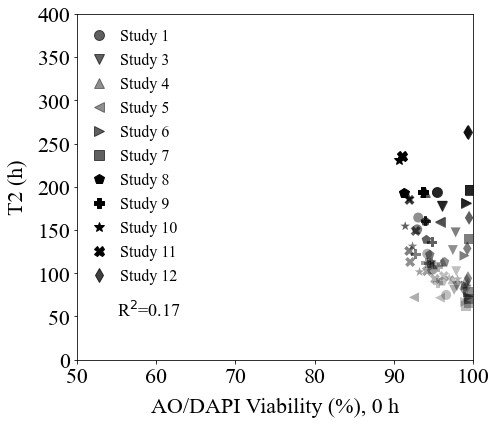

In [18]:
all_markers = ["o","v","^","<",">","s","p","P","*","X","d","D"]

studies = ['Study1','Study3','Study4','Study5','Study6','Study7','Study8','Study9','Study10','Study11','Study12']

#studies = ['Study1','Study3','Study4','Study5','Study6','Study7','Study8','Study9','Study10','Study11','Study12']

fig, axs = plt.subplots(figsize=(7,6))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

mi = 0

for s in studies:
    labelname = s.replace('Study','Study ')
    
    alpha_s = 0.75*np.array(ths[s+'_TH'])/60.0 + 0.25
    
    plt.scatter(aodapis_d0[s+'_AODAPI'],t2s_d0[s+'_T2'],marker=all_markers[mi],s=100,color='black',alpha=alpha_s,linewidth=0)

    plt.plot(aodapis_d0[s+'_AODAPI'][-1],t2s[s+'_T2'][-1],marker=all_markers[mi],ms=10,color='black',alpha=alpha_s[-1],linewidth=0,label=labelname)

    mi += 1
    
plt.xticks(size=22)
plt.yticks(size=22)  
plt.xlabel(r'AO/DAPI Viability (%), 0 h',size=22,labelpad=10)
plt.ylabel(r'T2 (h)',size=22,rotation=90,labelpad=10)
plt.xlim(50,100)
plt.ylim(0,400)
plt.text(55,50,r'R$^2$='+r2,fontsize=18)

plt.legend(frameon=False,prop={'size': 16,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper left')
plt.tight_layout()

plt.savefig('AODAPI_day0-totalset-v2.png',dpi=300)

In [ ]:
print(result.rvalue**2)